In [1]:
%matplotlib inline

In [2]:
import numpy as np
import codecs
from sklearn.preprocessing import normalize

#### training data

In [254]:
# file = '../data/raw_data/customer_all.utf8.lengt3.seg.uniq.tsv'  # hanlp segmentation
training_file = '../data/segment_data/customer_sentences.txt'  # 
def parse_file(file):
    data = open(file, 'r').readlines()
    seg_sentences, raw_sentences = zip(* [(l.split('\t')[0], l.split('\t')[1].strip()) for l in data] )
    data_array = np.array([(l.split('\t')[0], l.split('\t')[1]) for l in data])
    return data, data_array, seg_sentences, raw_sentences

In [262]:
data, data_array, seg_sentences, raw_sentences = parse_file(training_file)
data_array.shape

(19545, 2)

#### labeled data

In [349]:
labeled_file = '../data/labeled_data/sales_state/20180327_r1.seg.txt'
labeled_data, labeled_data_array, labeled_seg_sentences, labeled_raw_sentences = parse_file(labeled_file)
labeled_data_array.shape

(893, 2)

In [350]:
import fastText as ft

In [265]:
# learned word vectors based on hanlp segmentation
# model = ft.load_model('/search/nenggong/customer_service/data/ft_res/yangguang500h_fasttext/ft_res_default.bin')
# model = ft.load_model('/search/nenggong/customer_service/data/ft_res/query_all_fasttext/ft_res_ws8_d300.bin')

# 基于百度知道-未知分词 训练的词向量
model = ft.load_model('/search/nenggong/word-vectors/Henry_more_w2v_models/baidu_cbow_dim200-wN1.bin')

# pretrained word vectors based on stanford nlp segmentation
# model = ft.load_model('/search/nenggong/word-vectors/wiki.zh.bin')

# continue training with pretrained word vectors based on stanford nlp segmentation
# model = ft.load_model('/search/nenggong/customer_service/data/ft_res/query_all_fasttext/ft_res_ws8_d300_stfseg.bin')

In [7]:
def get_sent_vec(words):
    sentence_vectors = None
    for word in words:
        if sentence_vectors is None:
            sentence_vectors = model.get_word_vector(word)
        else:
            sentence_vectors = np.add(sentence_vectors, model.get_word_vector(word))
    return sentence_vectors / len(words)

In [198]:
s1 = '还有'.split()
s2 = '有'.split()
sv1 = get_sent_vec(s1)
sv2 = get_sent_vec(s2)
# print(sv1)
# print(model.get_word_vector('有'))
# print(model.get_word_vector('还有'))
print(np.linalg.norm(get_sent_vec(s1) - get_sent_vec(s2)))
print(np.linalg.norm(model.get_word_vector('还有') - model.get_word_vector('有')))
from scipy.spatial.distance import cosine
print(cosine(model.get_word_vector('还有'), model.get_word_vector('有')))
print(cosine(model.get_word_vector('还有'), model.get_word_vector('没有')))
print(cosine(model.get_word_vector('还有'), model.get_word_vector('还是')))

17.5791
17.5791
0.301846206188
0.412373363972
0.592962145805


In [276]:
def convert_seg_sents_to_np_vectors(data):
    l_word_vectors = []
    for l in data:
        words = l.strip().split()
        sentence_vectors = get_sent_vec(words)
        l_word_vectors.append(sentence_vectors)
    res = np.concatenate(l_word_vectors).reshape(len(data), -1)
    return res
rX = convert_seg_sents_to_np_vectors([l.split('\t')[0] for l in data])

rX.shape

(19545, 200)

In [313]:
print(type(rX.shape))
print('Extracted sentence wordvector feature, data shape is ', rX.shape)

<class 'tuple'>
Extracted sentence wordvector feature, data shape is  (19545, 200)


In [277]:
from sklearn.preprocessing import normalize
nrX = normalize(rX, norm='l2')

In [351]:
lX = convert_seg_sents_to_np_vectors([l.split('\t')[0] for l in labeled_data])
lX.shape

nlX = normalize(lX, norm='l2')

### ADD tfidf vector

In [268]:
stopwords = [l.strip() for l in open('/search/nenggong/libs/hanlp/data/dictionary/stopwords.txt', 'r', encoding='utf-8').readlines()]
n_features = 3000
logtf = True
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_df=0.5, max_features=n_features, min_df=2, sublinear_tf=logtf, stop_words=stopwords)
tX = tfidf_vec.fit_transform(seg_sentences)

In [269]:
print(tX.shape)

(19545, 1348)


In [270]:
from sklearn.externals import joblib
model_output_dir = '../data/models/customer_intent/'
import os
joblib.dump(tfidf_vec, os.path.join(model_output_dir, 'tfidf_vec.joblib.bin'))

['../data/models/tfidf_vec.joblib.bin']

In [271]:
tfX = tX.toarray()

In [272]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from time import time
n_components = 400
t0 = time()
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

ntX = lsa.fit_transform(tX)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

done in 3.171266s
Explained variance of the SVD step: 83%


In [273]:
from sklearn.externals import joblib
joblib.dump(lsa, os.path.join(model_output_dir, 'tfidf_svd_norm.joblib.bin'))

['../data/models/tfidf_svd_norm.joblib.bin']

In [274]:
print(ntX.shape, type(ntX))

(19545, 400) <class 'numpy.ndarray'>


In [279]:
anX = np.hstack((nrX, ntX))
print(anX.shape)

(19545, 600)


In [280]:
np.savetxt('../data/train_data_sentvec_tfidf_svd_norm.txt', anX)

In [303]:
from sklearn.neighbors import NearestNeighbors
n_nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', metric='euclidean').fit(anX)

#### ADD labeled data tfidf

In [352]:
trained_tfidf_vectorizer = joblib.load(os.path.join(model_output_dir, 'tfidf_vec.joblib.bin'))
trained_svd_norm = joblib.load(os.path.join(model_output_dir, 'tfidf_svd_norm.joblib.bin'))
labeled_tfidf = trained_svd_norm.transform(trained_tfidf_vectorizer.transform(labeled_seg_sentences))
print(type(labeled_tfidf), labeled_tfidf.shape)

<class 'numpy.ndarray'> (893, 400)


In [334]:
test_seg_sents = ['巴拉', 'rd', '我 现在']
test_sentvec = convert_seg_sents_to_np_vectors(test_seg_sents)
test_tfidf = trained_svd_norm.transform(trained_tfidf_vectorizer.transform(test_seg_sents))
test_norm = np.hstack((test_sentvec, test_tfidf))
print(test_norm)
# dis, idx = n_nbrs.kneighbors(test_norm, n_neighbors=5, return_distance=True)
# idx

[[ -2.06214651e-01   1.23023224e+00   1.38554549e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -5.28858066e-01   1.49864461e-02  -1.09659538e-01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.97333479e+00   2.44040981e-01  -1.58144772e+00 ...,  -2.36134127e-05
   -3.48229892e-04   5.08693757e-04]]


In [353]:
alX = np.hstack((nlX, labeled_tfidf))
alX.shape

(893, 600)

In [354]:
alX

array([[ 0.13468793,  0.00975122, -0.15918216, ...,  0.00492679,
         0.0083705 , -0.00241391],
       [ 0.12172928, -0.01367251, -0.15055107, ...,  0.00247462,
         0.00425071,  0.00555485],
       [ 0.14186642, -0.01219963, -0.13349549, ...,  0.00329667,
         0.00717102, -0.00094   ],
       ..., 
       [ 0.12854084, -0.00913093, -0.11256139, ...,  0.00142888,
         0.00418008,  0.00497635],
       [ 0.11950731, -0.03290087, -0.08367974, ..., -0.00363487,
        -0.03484371, -0.03380535],
       [ 0.15635104, -0.03850982, -0.11089469, ...,  0.00381131,
         0.00625975,  0.00156867]])

In [331]:
%ls `pwd`/../data/labeled_data/customer_intent

20180314_r1.seg.txt  20180321_r1.features.txt  20180321_r1.seg.txt
20180314_r1.txt      20180321_r1.label.txt     20180321_r1.txt


In [355]:
np.savetxt('../data/labeled_data/sales_state/20180327_r1.features.txt', alX)

In [324]:
alX_copy = np.loadtxt('../data/labeled_data/customer_intent/20180321_r1.features.txt')

In [332]:
distances_cp, indices_cp = n_nbrs.kneighbors(alX_copy, n_neighbors=3, return_distance=True)

array([[15723, 13459,   937],
       [17307,  5359, 17345],
       [ 7615, 13575,  1472]])

In [333]:
indices_cp[:3,:]

array([[15723, 13459,   937],
       [17307,  5359, 17345],
       [ 7615, 13575,  1472]])

In [305]:
distances, indices = n_nbrs.kneighbors(alX, n_neighbors=3, return_distance=True)

In [259]:
rindices = nbrs.radius_neighbors(alX, radius=.5, return_distance=False)

In [207]:
distances

array([[  5.32045924e-02,   9.14465085e-01,   9.76573052e-01,
          1.13330201e+00,   1.14135673e+00],
       [  2.97852722e-04,   4.47935975e-01,   4.76321261e-01,
          5.03678512e-01,   5.16732783e-01],
       [  2.97852722e-04,   3.83169415e-01,   6.00673798e-01,
          6.63387045e-01,   6.68158425e-01],
       ..., 
       [  6.04220516e-01,   9.15276678e-01,   9.23144684e-01,
          9.57792720e-01,   9.98919213e-01],
       [  9.25037663e-04,   8.99359901e-01,   9.67957830e-01,
          9.85233193e-01,   1.00086761e+00],
       [  1.06752952e-03,   4.58485473e-01,   4.98018322e-01,
          4.98933908e-01,   5.87820214e-01]])

In [286]:
print(type(indices), indices.shape)
print(type(rindices), rindices.shape)
print(type(rindices.tolist()[0]))
print(len(indices[:,0]))
indices[:,0]

<class 'numpy.ndarray'> (1195, 5)
<class 'numpy.ndarray'> (1195,)
<class 'numpy.ndarray'>
1195


array([15723, 17307,  7615, ..., 18813,  2545, 18164])

In [234]:
sdf = pd.DataFrame(indices)
sdf['g'] = sdf.index > 10
sdf.groupby(['g'])

In [211]:
print(indices.shape)
indices[:,:2].shape

(722, 5)


(722, 2)

#### get reliable sentences and its labels by radius

In [306]:
output_file_name = '../data/to_label_data/customer_intent/0321_recall_from0313_knbrs.txt'
seed_labels = np.loadtxt('../data/labeled_data/customer_intent/20180321_r1.label.txt', dtype='str')
nbrs_list = indices.tolist()
# print(nbrs_list)
label_list = seed_labels.tolist()
assert len(nbrs_list) == len(label_list)
from collections import defaultdict
label2sentence_indice = defaultdict(set)
for label, nbrs in zip(label_list, nbrs_list):
    if isinstance(nbrs, np.ndarray):
        nbrs = nbrs.tolist()
#     print(nbrs)
    label2sentence_indice[label] = label2sentence_indice[label] | set(nbrs)
with open(output_file_name, 'w') as of:
    for label, sentence_indice in label2sentence_indice.items():
        for si in sentence_indice:
#             print(label,  raw_sentences[si].strip())
            if raw_sentences[si].strip() not in labeled_raw_sentences:
                of.write('\t'.join([str(int(label)), raw_sentences[si].strip()]) + '\n')

In [288]:
nbrs0 = [int(idx) for idx in np.nditer(indices[:,0], order='F')]
nbrs1 = [int(idx) for idx in np.nditer(indices[:,1], order='F')]
nbrs2 = [int(idx) for idx in np.nditer(indices[:,2], order='F')]
print(len(nbrs0), len(nbrs1))
uniq_nbrs = set(nbrs0) | set(nbrs1) | set(nbrs2)
to_label_sentences = [raw_sentences[i] for i in uniq_nbrs if raw_sentences[i] not in labeled_raw_sentences]
similar_sentence_pairs = [(labeled_raw_sentences[i], raw_sentences[j]) for i, j in zip(range(0, len(labeled_raw_sentences)), nbrs0) if labeled_raw_sentences[i] != raw_sentences[j]]
print(len(similar_sentence_pairs))
similar_sentence_pairs += [(labeled_raw_sentences[i], raw_sentences[j]) for i, j in zip(range(0, len(labeled_raw_sentences)), nbrs1) if labeled_raw_sentences[i] != raw_sentences[j]]
print(len(similar_sentence_pairs))
similar_sentence_pairs += [(labeled_raw_sentences[i], raw_sentences[j]) for i, j in zip(range(0, len(labeled_raw_sentences)), nbrs2) if labeled_raw_sentences[i] != raw_sentences[j]]
print(len(similar_sentence_pairs))
similar_sentence_pairs += [(raw_sentences[i], raw_sentences[j]) for i, j in zip(nbrs0, nbrs1) if raw_sentences[i] != raw_sentences[j]]
print(len(similar_sentence_pairs))
with open('../data/to_label_data/0321_recalled_by_sim_of20180313.txt', 'w') as wf:
    wf.write('\n'.join(to_label_sentences))
with open('../data/to_label_data/0321_sim_sent_pairs_from20180313.txt', 'w') as wf2:
    wf2.write('\n'.join([a + '\t' + b for a, b in similar_sentence_pairs]))

1195 1195
122
1305
2497
3692


#### NO Normalization

In [29]:
# print(rX.shape)
# aX = np.hstack((rX, tX))
print(rX.shape, tX.shape)
aX = np.hstack((rX, tfX))

(12337, 300) (12337, 1739)


## Clustering

### KMeans

In [341]:
n_clusters = 300
from sklearn.cluster import KMeans
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, n_jobs=12)

In [342]:
from time import time
t0 = time()
km.fit(anX)
print("kmeans done in %0.3fs" % (time() - t0))
print("kmeans inertia: ", km.inertia_)

kmeans done in 133.968s
kmeans inertia:  12251.7167001


In [178]:
joblib.dump(km, '../data/models/kmeans_300.joblib.bin')

['../data/models/kmeans_300.joblib.bin']

In [ ]:
trained_kmeans = joblib.load('../data/models/kmeans_300.joblib.bin')

### GMM

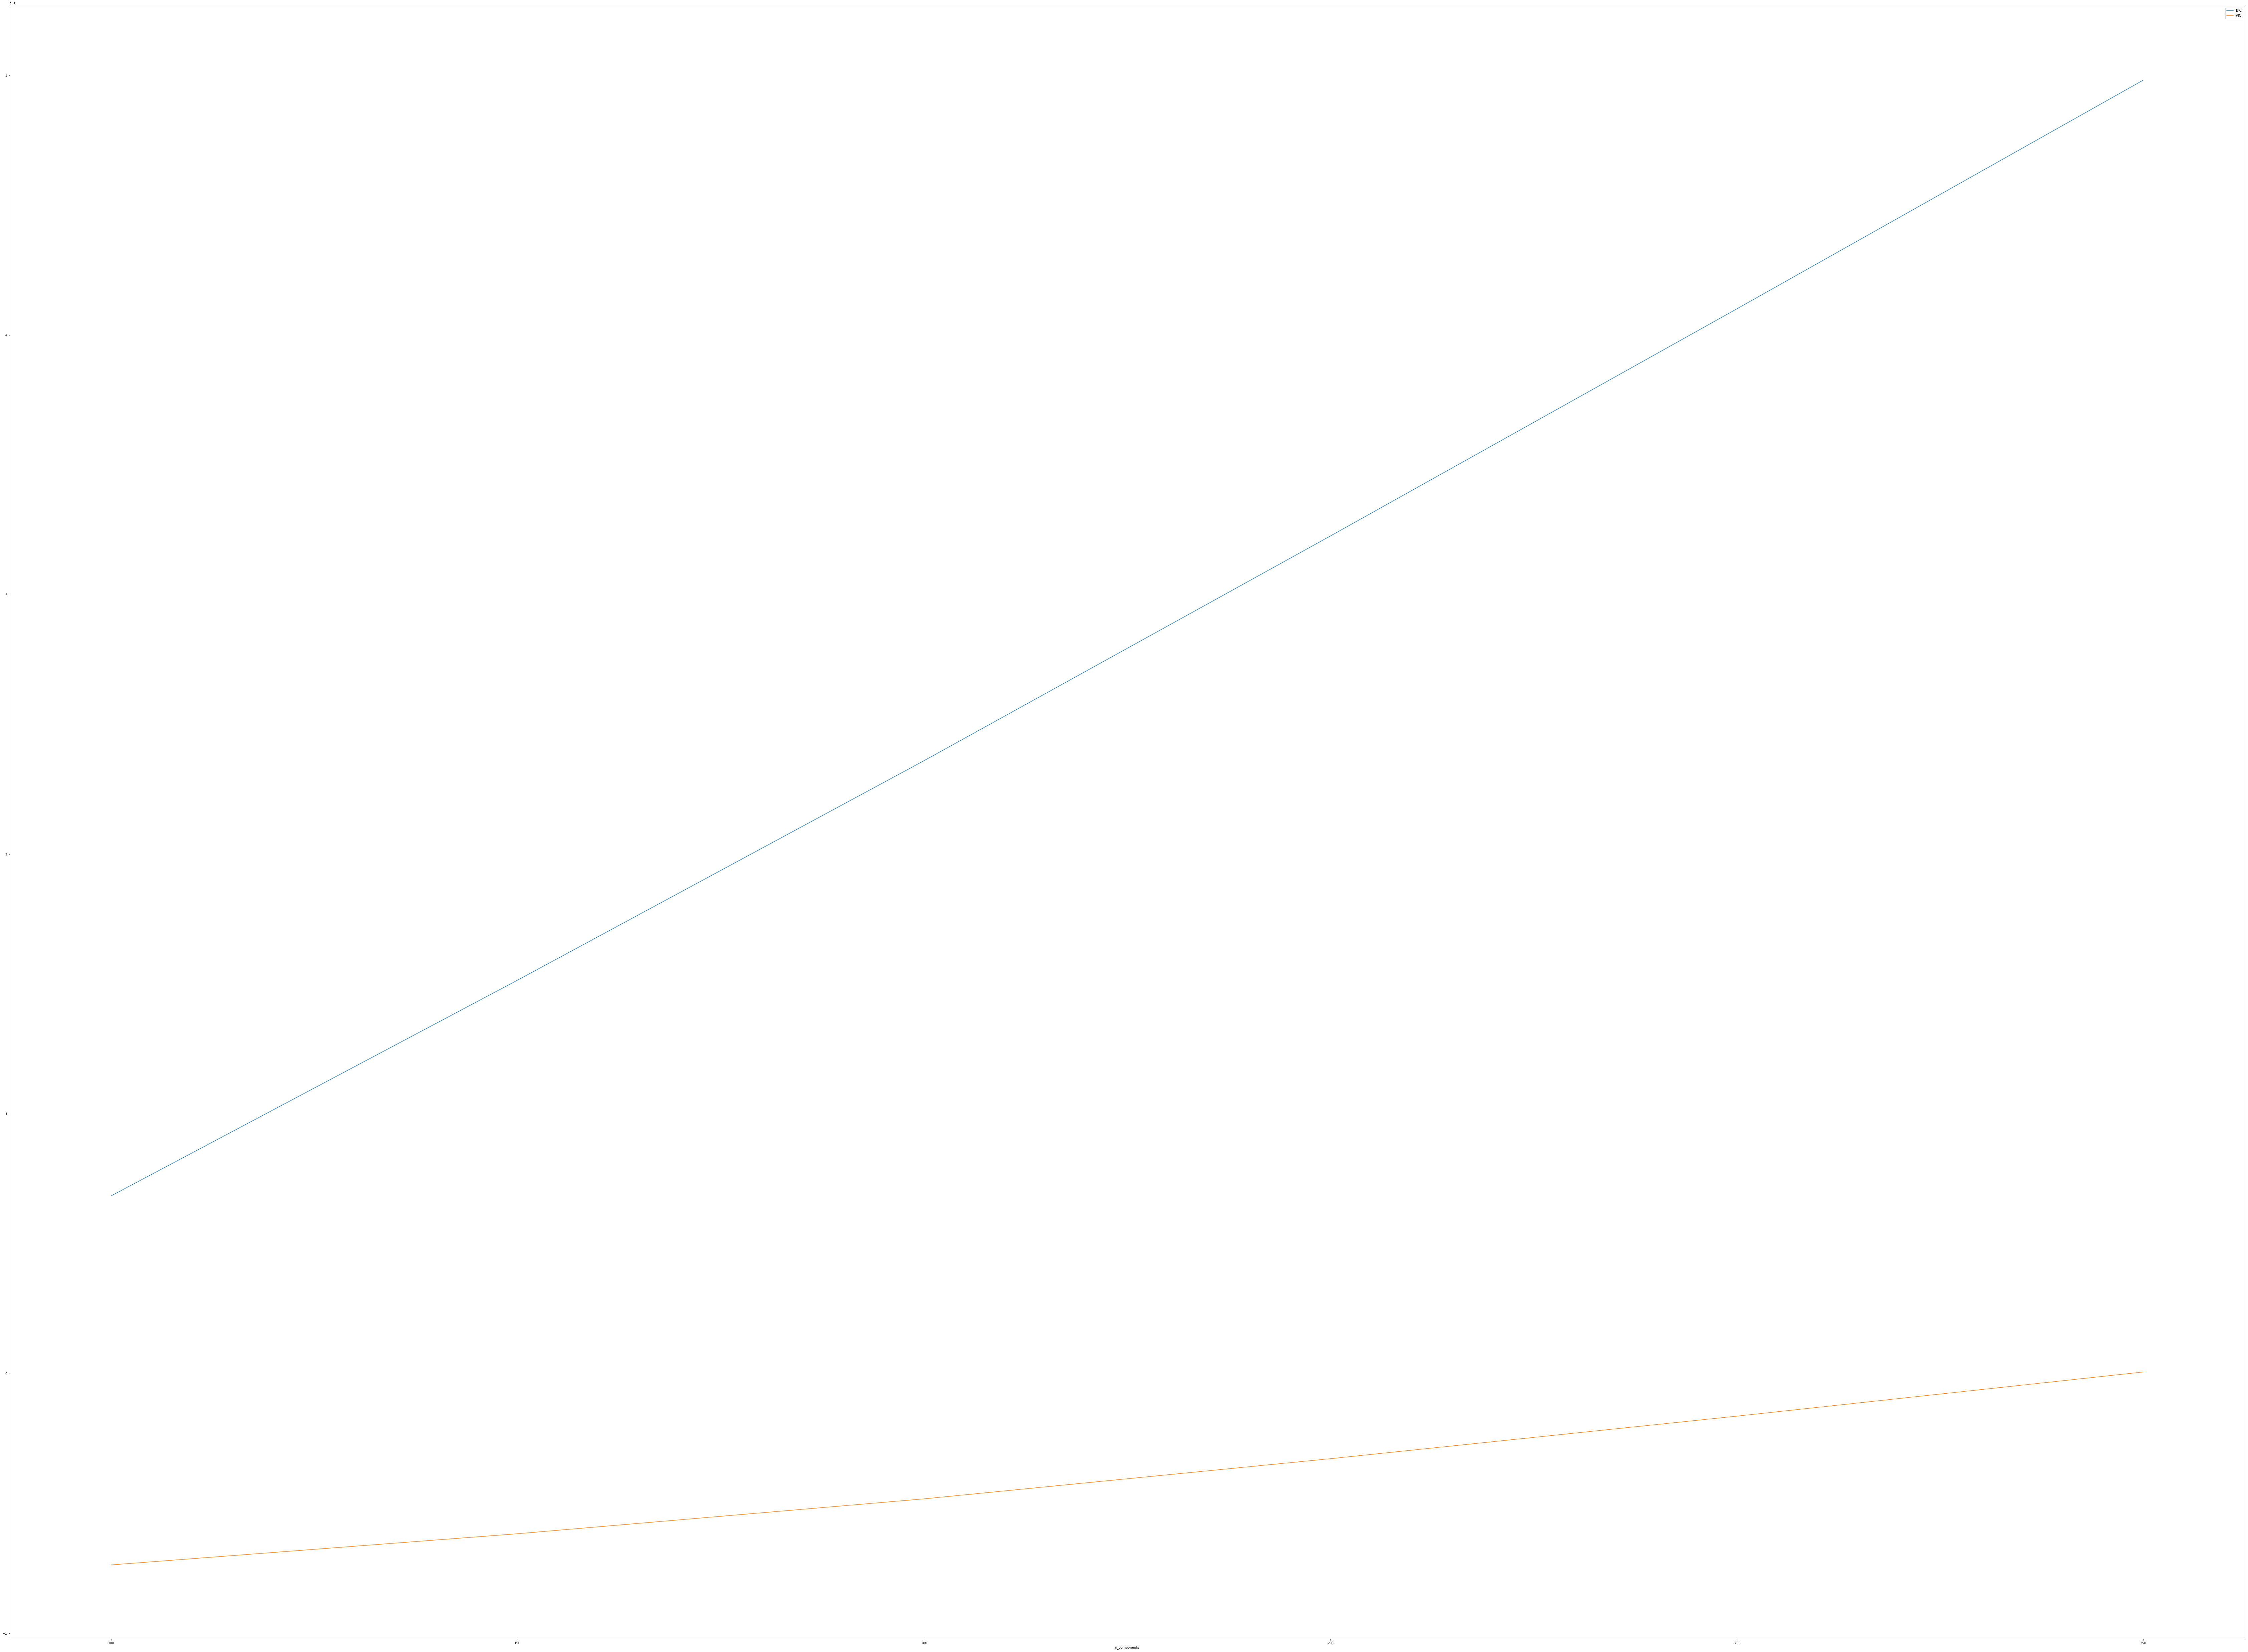

In [136]:
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

n_components = np.arange(100, 400, 50)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(anX)
          for n in n_components]

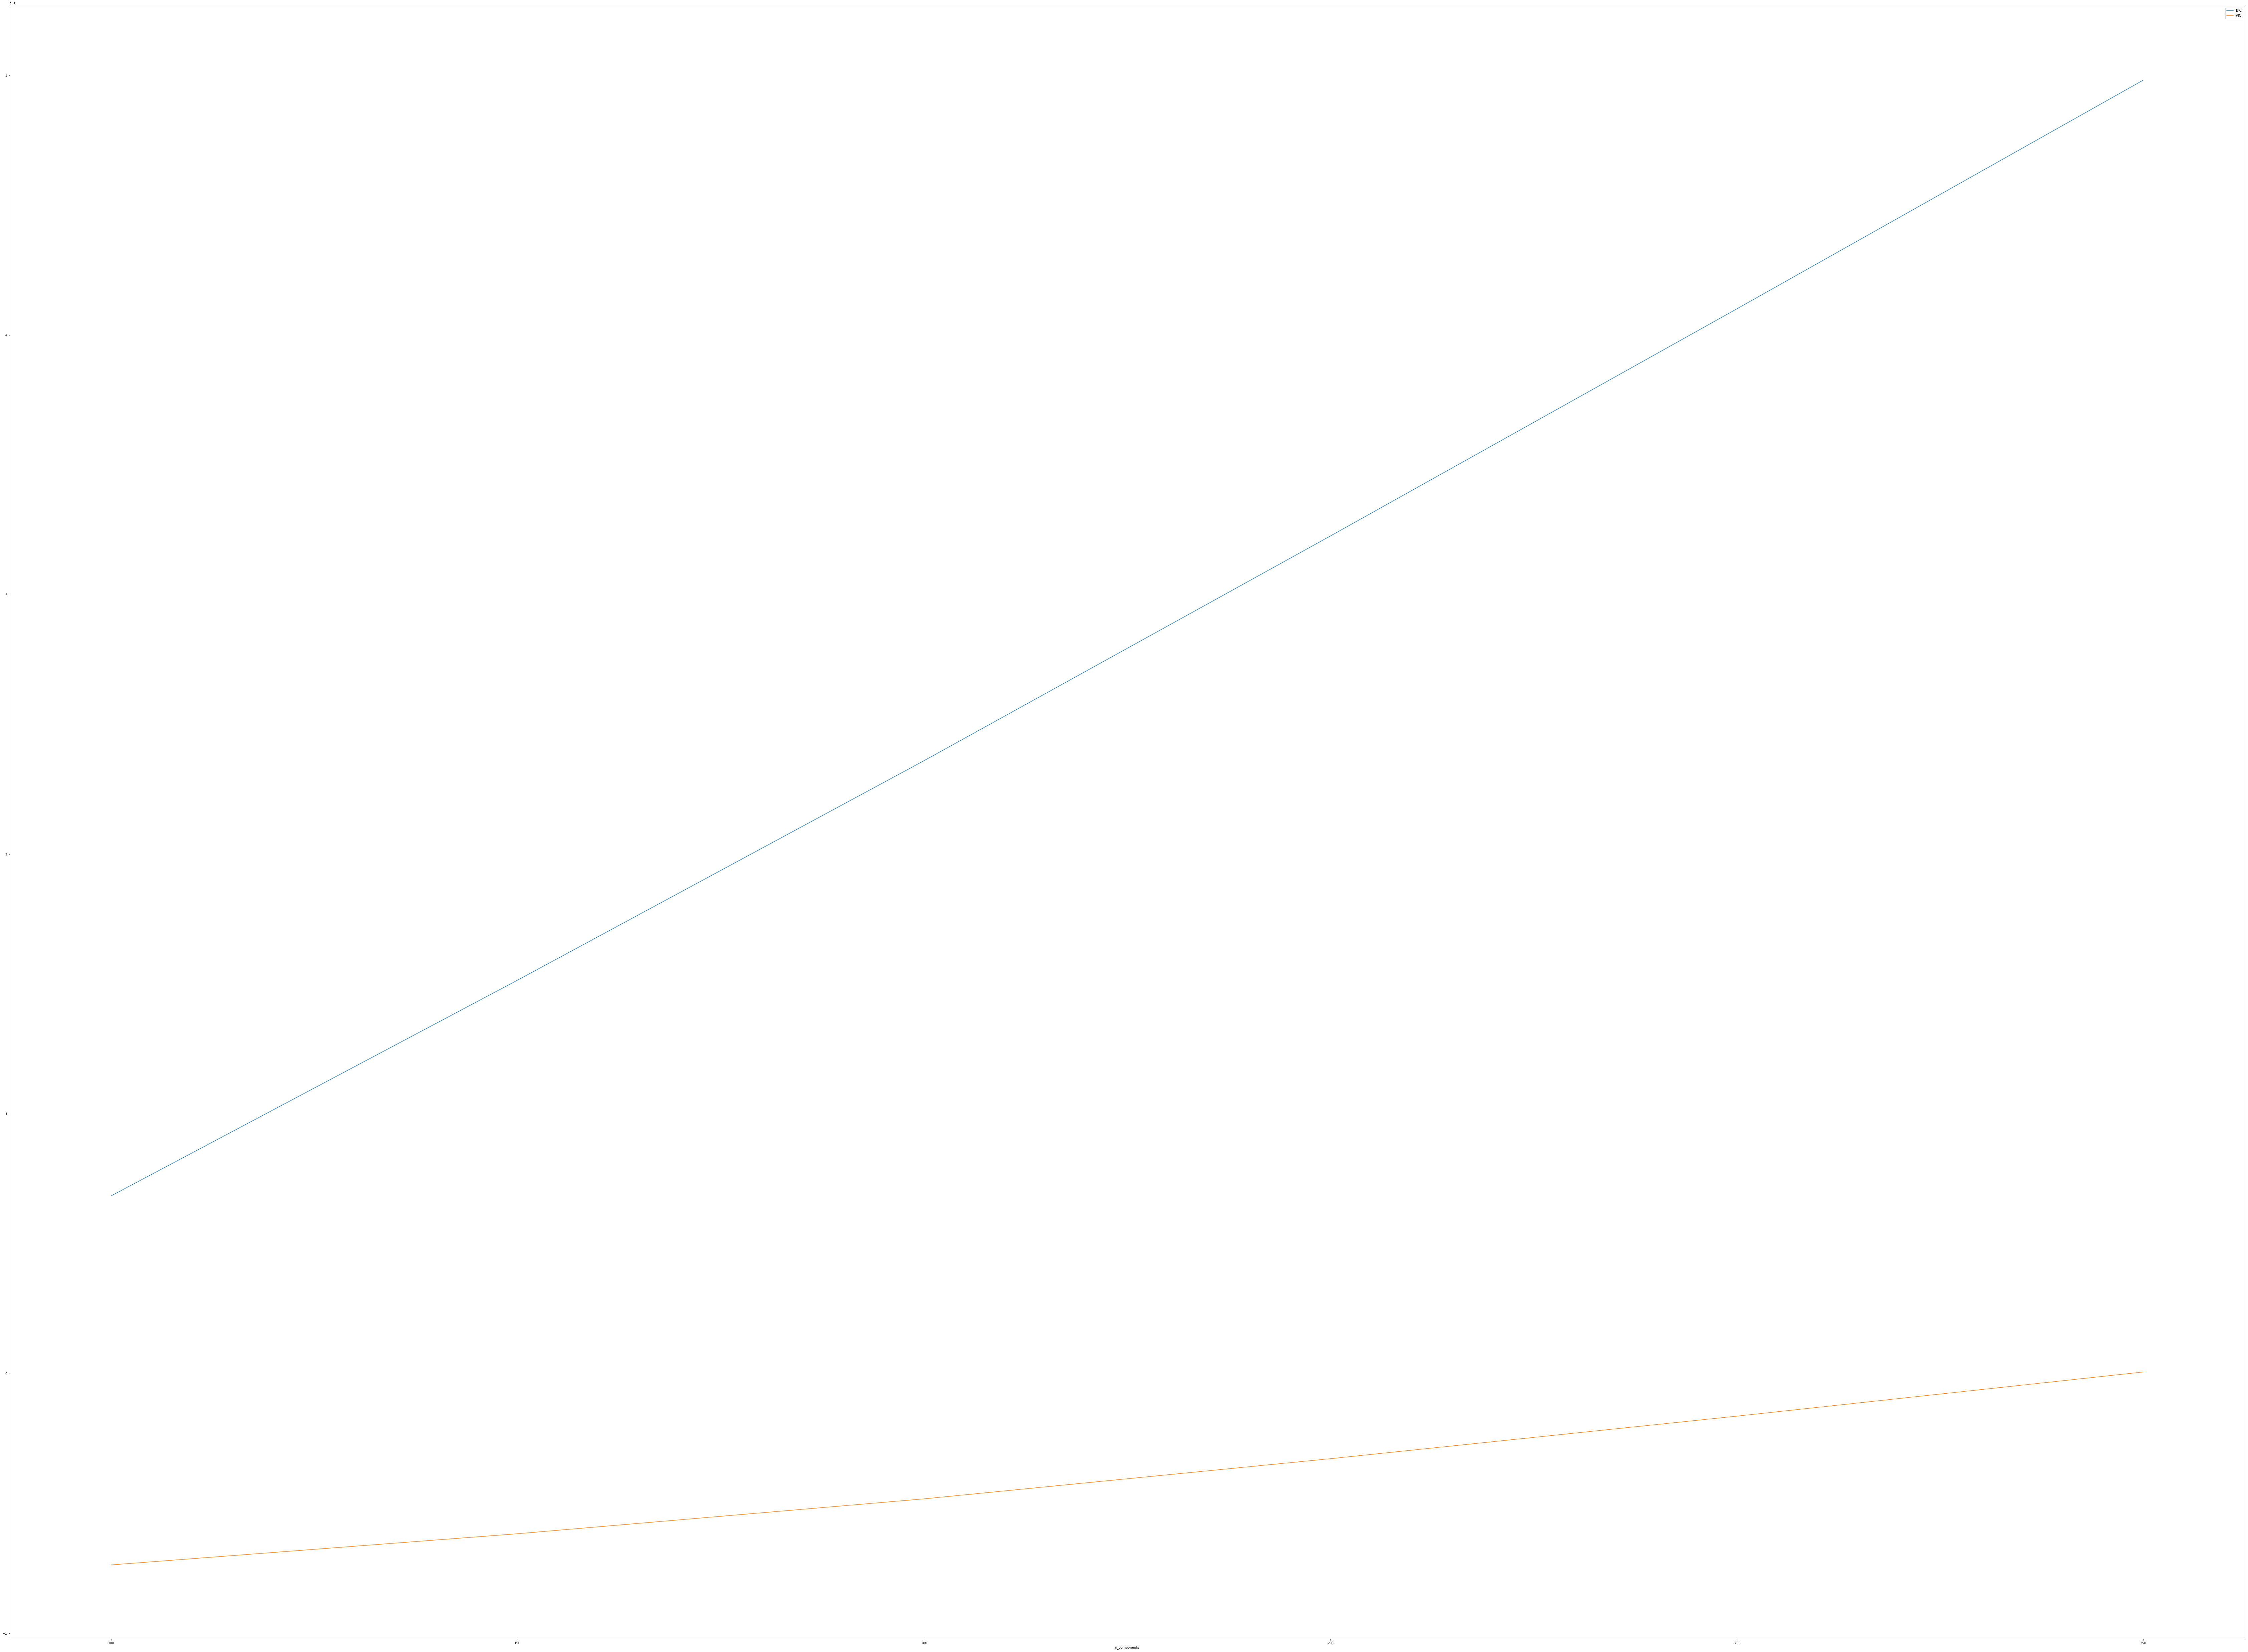

In [147]:
plt.plot(n_components, [m.bic(anX) for m in models], label='BIC')
plt.plot(n_components, [m.aic(anX) for m in models], label='AIC')
plt.rcParams["figure.figsize"] = [10, 15] 
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

In [ ]:
model100, model150, model200 = models[0], models[1], models[2]
model100_preds = model100.predict(anX)
model150_preds = model150.predict(anX)
model200_preds = model200.predict(anX)

In [143]:
model300 = models[4]
model300_preds = model300.predict(anX)

In [153]:
print(Counter(model300_preds).most_common(20))
print(Counter(model300_preds).keys())

[(31, 294), (135, 294), (6, 288), (11, 283), (26, 179), (169, 178), (270, 173), (7, 165), (94, 163), (20, 154), (10, 153), (189, 153), (228, 153), (170, 152), (112, 151), (251, 149), (113, 144), (52, 143), (101, 142), (243, 140)]
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,

### DBSCAN

In [134]:
from sklearn.cluster import DBSCAN
eps = 0.5
min_samples = 10
db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=12)

from time import time
t0 = time()
dbs = db.fit(anX)
print("dbscan done in %0.3fs" % (time() - t0))

from collections import Counter
print(Counter(dbs.labels_))

Counter({-1: 14897,
         0: 24,
         1: 26,
         2: 226,
         3: 133,
         4: 27,
         5: 179,
         6: 13,
         7: 2833,
         8: 65,
         9: 12,
         10: 41,
         11: 172,
         12: 46,
         13: 47,
         14: 25,
         15: 66,
         16: 23,
         17: 10,
         18: 16,
         19: 40,
         20: 6,
         21: 32,
         22: 19,
         23: 11,
         24: 12,
         25: 8,
         26: 14,
         27: 22,
         28: 13,
         29: 11,
         30: 10,
         31: 10,
         32: 8,
         33: 10})

### Hierarchical Clustering

In [124]:
from sklearn.cluster import AgglomerativeClustering
n_clusters = 300
agc = AgglomerativeClustering(n_clusters=n_clusters)

from time import time
t0 = time()
ward = agc.fit(rX)
print("ward done in %0.3fs" % (time() - t0))

print(Counter(ward.labels_).most_common(20))

[(13, 462),
 (46, 426),
 (113, 318),
 (6, 304),
 (90, 272),
 (21, 254),
 (75, 246),
 (54, 229),
 (61, 213),
 (62, 213),
 (111, 203),
 (191, 195),
 (139, 187),
 (210, 187),
 (187, 182),
 (12, 180),
 (279, 178),
 (112, 171),
 (105, 170),
 (33, 167)]

#### 手动获取label对应的数据

In [68]:
data_labels = list(zip([d.split('\t')[0] for d in data], ward.labels_))
def get_points_of_label(index):
    query_cluster = []
    for query, label in data_labels:
        if label == index:
            query_cluster.append(query)
    return query_cluster

c = get_points_of_label(37)
print('\n'.join(c))

### clusters std plot

In [339]:
# Counter(km.labels_)
print(len(data), anX.shape)

19545 (19545, 600)


In [343]:
from collections import Counter
# KMeans
d = km.transform(anX)
preds = km.labels_
# GMM
# d = model300.predict_proba(anX)
# preds = model300.predict(anX)

print(d.shape)
# print(d[0,270:])
import pandas as pd
d_columns = ['f_%s' % k for k in Counter(preds).keys()] + ['label_id']
# df = pd.DataFrame(np.concatenate((d, preds.reshape(len(data), 1)), axis=1))
df = pd.DataFrame(np.concatenate((d, preds.reshape(len(data), 1)), axis=1), columns=d_columns)
print(df.head(1))
# print(type(df.iloc[:,0]))
def get_distance_to_center(row):
    return row[int(row['label_id'])]
    # return row['f_%s' % int(row['label_id'])]
df['dis2center'] = df.apply(get_distance_to_center, axis=1)
# df.head(10)
# center_std_df = df.groupby(300)['dis2center'].std().reset_index().rename(columns={300:'label_id','dis2center' : 'std'})
new_col_name = {'std': 'std', 'mean': 'mean'}
center_std_df = df.groupby('label_id').agg({'dis2center': ['mean', 'std']})#.reset_index().rename(columns={300:'label_id','dis2center' : 'std'})
center_std_df.columns = center_std_df.columns.droplevel(0)
center_std_df = center_std_df.reset_index().rename(columns=new_col_name)
# center_std_df.columns = ['label_id', 'std']
print('center_std_df...')
center_std_df.head(1)
# from matplotlib.pyplot as plt

(19545, 300)
        f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
0  1.504236  1.545344  1.525369  1.392748  1.212056  1.375363  1.342723   

        f_7       f_8       f_9    ...        f_291     f_292    f_293  \
0  1.594803  1.560227  1.410538    ...     1.217224  1.803704  1.47393   

      f_294     f_295     f_296     f_297     f_298     f_299  label_id  
0  1.196208  1.517687  1.719518  1.273093  1.296759  1.573734      25.0  

[1 rows x 301 columns]
center_std_df...


label_id      mean      std
0       0.0  0.723316  0.17224

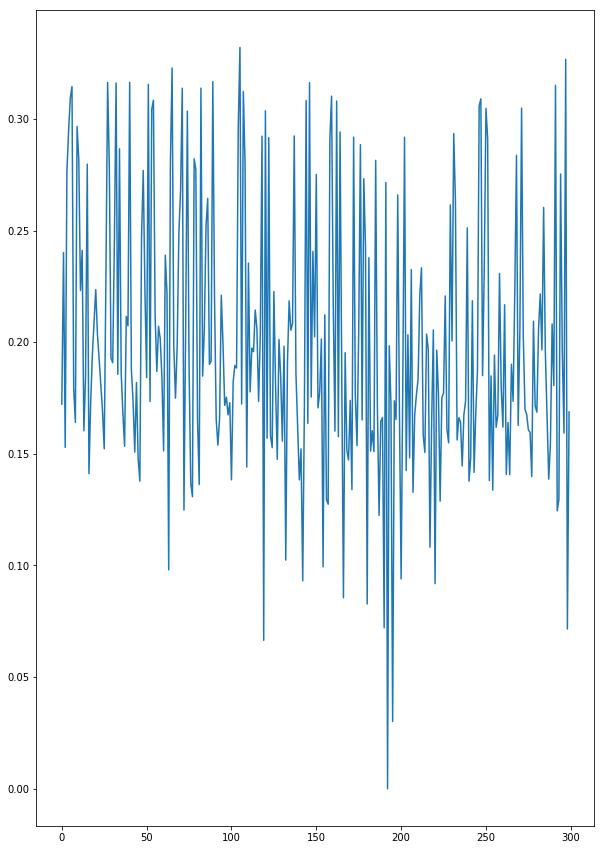

In [344]:
center_std_df['std'].plot(figsize=(10, 15))

In [348]:
center_std_df['std'].quantile(0.8)

0.26056377578361345

In [158]:
center_std_df[center_std_df['std'] > 0.0001]['label_id'].unique()

array([   7.,   30.,  135.,  189.])

### label_id, distance_to_center,raw_sentences

In [154]:
raw_data_df = pd.DataFrame({'sent': data_array[:,1].ravel()})
raw_sentence_label_dis = pd.concat([df['label_id'], df['dis2center'], raw_data_df['sent']], axis=1, keys=['label_id', 'distance', 'sent'])

In [155]:
join_df = pd.merge(center_std_df, raw_sentence_label_dis, on='label_id')

In [156]:
Counter(preds).most_common(20)

[(31, 294),
 (135, 294),
 (6, 288),
 (11, 283),
 (26, 179),
 (169, 178),
 (270, 173),
 (7, 165),
 (94, 163),
 (20, 154),
 (10, 153),
 (189, 153),
 (228, 153),
 (170, 152),
 (112, 151),
 (251, 149),
 (113, 144),
 (52, 143),
 (101, 142),
 (243, 140)]

In [91]:
sup1_labels = set([int(l) for l in center_std_df[center_std_df['std'] > 0.25]['label_id'].unique()])
sup2_labels = set([l for l, _ in Counter(km.labels_).most_common(20)])
print(sup1_labels)
print(sup2_labels)
sup_labels = sup1_labels & sup2_labels
print(sup_labels)

{128, 1, 130, 3, 4, 132, 133, 7, 258, 9, 137, 11, 139, 13, 14, 140, 264, 266, 273, 147, 148, 21, 279, 152, 280, 28, 156, 30, 31, 285, 33, 162, 289, 37, 39, 168, 296, 42, 50, 178, 183, 184, 57, 186, 59, 64, 70, 73, 89, 91, 93, 225, 226, 227, 100, 232, 106, 236, 110, 112, 252, 118, 123, 124, 254, 127}
{1, 130, 258, 225, 3, 132, 39, 264, 236, 14, 15, 112, 118, 184, 152, 89, 123, 156, 285, 30}
{1, 130, 3, 258, 132, 225, 39, 264, 236, 14, 112, 118, 184, 89, 285, 123, 156, 152, 30}


In [163]:
join_df[join_df['label_id'] == 10].head(20)

label_id  mean  std  distance               sent
1033      10.0   1.0  0.0       1.0        我现在换另外放的了\n
1034      10.0   1.0  0.0       1.0  还有现在就是我们那个天上人间洗\n
1035      10.0   1.0  0.0       1.0         我现在在办公室了\n
1036      10.0   1.0  0.0       1.0       嗯 我现在不 我现在\n
1037      10.0   1.0  0.0       1.0            嗯 我现在\n
1038      10.0   1.0  0.0       1.0            嗯 现在还\n
1039      10.0   1.0  0.0       1.0      就是说第四个 我现在在\n
1040      10.0   1.0  0.0       1.0              现在我\n
1041      10.0   1.0  0.0       1.0           我现在也在吗\n
1042      10.0   1.0  0.0       1.0              他现在\n
1043      10.0   1.0  0.0       1.0         他现在在飞机上a\n
1044      10.0   1.0  0.0       1.0           现在还没到吗\n
1045      10.0   1.0  0.0       1.0           现在 我现在\n
1046      10.0   1.0  0.0       1.0         啊 现在我还没到\n
1047      10.0   1.0  0.0       1.0              到现在\n
1048      10.0   1.0  0.0       1.0           嗯 现在不放\n
1049      10.0   1.0  0.0       1.0            现在我也不\n
1050      10.0   1.0  0.0       1.0          还行 现在 嗯\n
1051      10.0   1.0  0.0       1.0          我现在还没到吧\n
1052      10.0   1.0  0.0       1.0           就说那个现在\n

In [104]:
theta_ratio = 1
some_label = 155
theta_filter = (join_df['distance'] > join_df['mean'] - theta_ratio * join_df['std']) & (join_df['distance'] < join_df['mean'] + theta_ratio * join_df['std']) 
most_common_filter = ~join_df['label_id'].isin(sup_labels)
filter_cond = (theta_filter) & (most_common_filter) 
filtered_df = join_df[filter_cond]
# filtered_df.sort_values('distance').head(10)
# filtered_df.groupby('label_id').apply(lambda x: x.sort_values(['distance', 'sent'], ascending=True).head(3))
wdf = filtered_df.groupby('label_id').apply(lambda x: x.sort_values(['distance', 'sent'], ascending=True).head(5))

In [105]:
wdf['sent'] = wdf['sent'].apply(lambda x: x.strip())
wdf

label_id      mean       std  distance  \
label_id                                                 
0.0      19          0.0  0.720851  0.195194  0.529961   
         8           0.0  0.720851  0.195194  0.540704   
         22          0.0  0.720851  0.195194  0.554401   
         1           0.0  0.720851  0.195194  0.569352   
         21          0.0  0.720851  0.195194  0.578324   
2.0      248         2.0  0.744324  0.154011  0.635692   
         255         2.0  0.744324  0.154011  0.657019   
         245         2.0  0.744324  0.154011  0.676305   
         237         2.0  0.744324  0.154011  0.683049   
         250         2.0  0.744324  0.154011  0.706951   
4.0      448         4.0  0.823389  0.317142  0.509699   
         425         4.0  0.823389  0.317142  0.518355   
         492         4.0  0.823389  0.317142  0.522392   
         449         4.0  0.823389  0.317142  0.533097   
         455         4.0  0.823389  0.317142  0.533435   
5.0      497         5.0  0.764660  0.110139  0.704704   
         501         5.0  0.764660  0.110139  0.792594   
         498         5.0  0.764660  0.110139  0.813518   
6.0      585         6.0  0.542372  0.145930  0.398426   
         565         6.0  0.542372  0.145930  0.399012   
         576         6.0  0.542372  0.145930  0.402735   
         567         6.0  0.542372  0.145930  0.403572   
         549         6.0  0.542372  0.145930  0.409887   
7.0      714         7.0  0.789758  0.287177  0.504151   
         671         7.0  0.789758  0.287177  0.512955   
         665         7.0  0.789758  0.287177  0.517786   
         639         7.0  0.789758  0.287177  0.519982   
         642         7.0  0.789758  0.287177  0.520583   
8.0      739         8.0  0.623031  0.222360  0.403034   
         753         8.0  0.623031  0.222360  0.428584   
...                  ...       ...       ...       ...   
294.0    18867     294.0  0.621336  0.155587  0.468852   
         18826     294.0  0.621336  0.155587  0.470143   
         18889     294.0  0.621336  0.155587  0.471657   
         18843     294.0  0.621336  0.155587  0.471749   
         18890     294.0  0.621336  0.155587  0.473929   
295.0    18913     295.0  0.772176  0.180772  0.591746   
         18914     295.0  0.772176  0.180772  0.598643   
         18912     295.0  0.772176  0.180772  0.627012   
         18910     295.0  0.772176  0.180772  0.637876   
         18909     295.0  0.772176  0.180772  0.638439   
296.0    18958     296.0  0.860715  0.302703  0.577850   
         18962     296.0  0.860715  0.302703  0.581024   
         18965     296.0  0.860715  0.302703  0.598808   
         18961     296.0  0.860715  0.302703  0.603227   
         18930     296.0  0.860715  0.302703  0.607300   
297.0    18983     297.0  0.686405  0.199127  0.488562   
         18991     297.0  0.686405  0.199127  0.498849   
         18979     297.0  0.686405  0.199127  0.541047   
         18987     297.0  0.686405  0.199127  0.541680   
         18982     297.0  0.686405  0.199127  0.560964   
298.0    19017     298.0  0.854192  0.127025  0.728180   
         18999     298.0  0.854192  0.127025  0.728599   
         19024     298.0  0.854192  0.127025  0.739895   
         19034     298.0  0.854192  0.127025  0.751637   
         19038     298.0  0.854192  0.127025  0.752103   
299.0    19090     299.0  0.955761  0.132015  0.829400   
         19052     299.0  0.955761  0.132015  0.838285   
         19102     299.0  0.955761  0.132015  0.868658   
         19085     299.0  0.955761  0.132015  0.871189   
         19073     299.0  0.955761  0.132015  0.882227   

                                                    sent  
label_id                                                  
0.0      19                              还有 那个到了再寄过来吧 好吧  
         8                                   哦 那到时候就过来再说  
         22                                       那你到过来吧  
         1                                        我们还上过来  
       

### WRITE to excel file

#### pandas to_excel

In [442]:
output_file = '../data/to_label_data/20180313.xlsx'
# writer = pd.ExcelWriter(output_file, engine='xlwt')
wdf['index'] = wdf.index.map(lambda x: x[1]) ## 修改dataframe的index
xls_writer = wdf[['index', 'label_id', 'sent']].to_excel(output_file, index=False)
# xls_writer.save()

#### raw data to excel by xlwt

In [441]:
tolabel_data = [('index', 'label_id', 'sentence')]

tolabel_data += [(index[1], row['label_id'], row['sent']) for index, row in wdf.iterrows()]
# print(tolabel_data)

def write_to_excel(output_file, data):
    import xlwt
    book = xlwt.Workbook(encoding='utf-8')
    sheet1 = book.add_sheet('Sheet1')
    for i, line in enumerate(data):
        for j, e in enumerate(line):
            sheet1.write(i, j, e)
    book.save(output_file)

write_to_excel('../data/to_label_data/201803131756.xls', tolabel_data)
#     print(wdf.loc[name])

#### ** 下面方法计算聚类中的句子是错误的 **

In [359]:
## 因为kmeans transform之后每行是句子离所有聚类中心点的距离，按列降序取top，不能保证在相应行也是此中心点最近
print(d[:,99])
c0 = np.argsort(d[:,91])[:92]
print('index:', c0)
data_array[c0][:,1]

def write_to_files():
    clustering_res_dir = '../data/clustering_res/kmeans_%s_dim_%s' % (n_clusters, rX.shape[1])
    import os
    if not os.path.exists(clustering_res_dir):
        os.mkdir(clustering_res_dir)

    from collections import Counter
    for label, cnt in Counter(km.labels_).items():
        cnt_idx = np.argsort(d[:, label])[:cnt]
        label_data_array = data_array[cnt_idx][:,1]
        print(label_data_array.shape)
        with open(clustering_res_dir + '/label_%s.txt' % label, 'w') as of:
            for x in np.nditer(label_data_array):
    #             print(x)
                of.write(str(x))

array([ 1.29738834,  1.27872314,  1.3577871 , ...,  1.32507797,
        1.31729197,  0.86107729])

## tsne visualizing

#### GET data frame to visualize

In [78]:
import pandas as pd

feat_cols = [ 'f'+str(i) for i in range(anX.shape[1]) ]

vdf = pd.DataFrame(anX,columns=feat_cols) # DATA to vis
vdf['label'] = km.labels_
vdf['label'] = vdf['label'].apply(lambda i: str(i))

X, y = None, None

print('Size of the dataframe: {}'.format(vdf.shape))

Size of the dataframe: (19107, 601)


#### 2D visualization

In [79]:
from time import time

from sklearn.manifold import TSNE

lr = 100
perplexity = 30
n_dims = 2
n_iter = 3000

time_start = time()
tsne = TSNE(n_components=n_dims, verbose=2, perplexity=perplexity, n_iter=n_iter, learning_rate=lr)
tsne_results = tsne.fit_transform(vdf.loc[:,feat_cols].values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19107 samples in 0.876s...
[t-SNE] Computed neighbors for 19107 samples in 478.547s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19107
[t-SNE] Computed conditional probabilities for sample 2000 / 19107
[t-SNE] Computed conditional probabilities for sample 3000 / 19107
[t-SNE] Computed conditional probabilities for sample 4000 / 19107
[t-SNE] Computed conditional probabilities for sample 5000 / 19107
[t-SNE] Computed conditional probabilities for sample 6000 / 19107
[t-SNE] Computed conditional probabilities for sample 7000 / 19107
[t-SNE] Computed conditional probabilities for sample 8000 / 19107
[t-SNE] Computed conditional probabilities for sample 9000 / 19107
[t-SNE] Computed conditional probabilities for sample 10000 / 19107
[t-SNE] Computed conditional probabilities for sample 11000 / 19107
[t-SNE] Computed conditional probabilities for sample 12000 / 19107
[t-SNE] Computed conditional probabilities for s

In [80]:
df_tsne = vdf.loc[:,:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

#### NO LABEL visualization

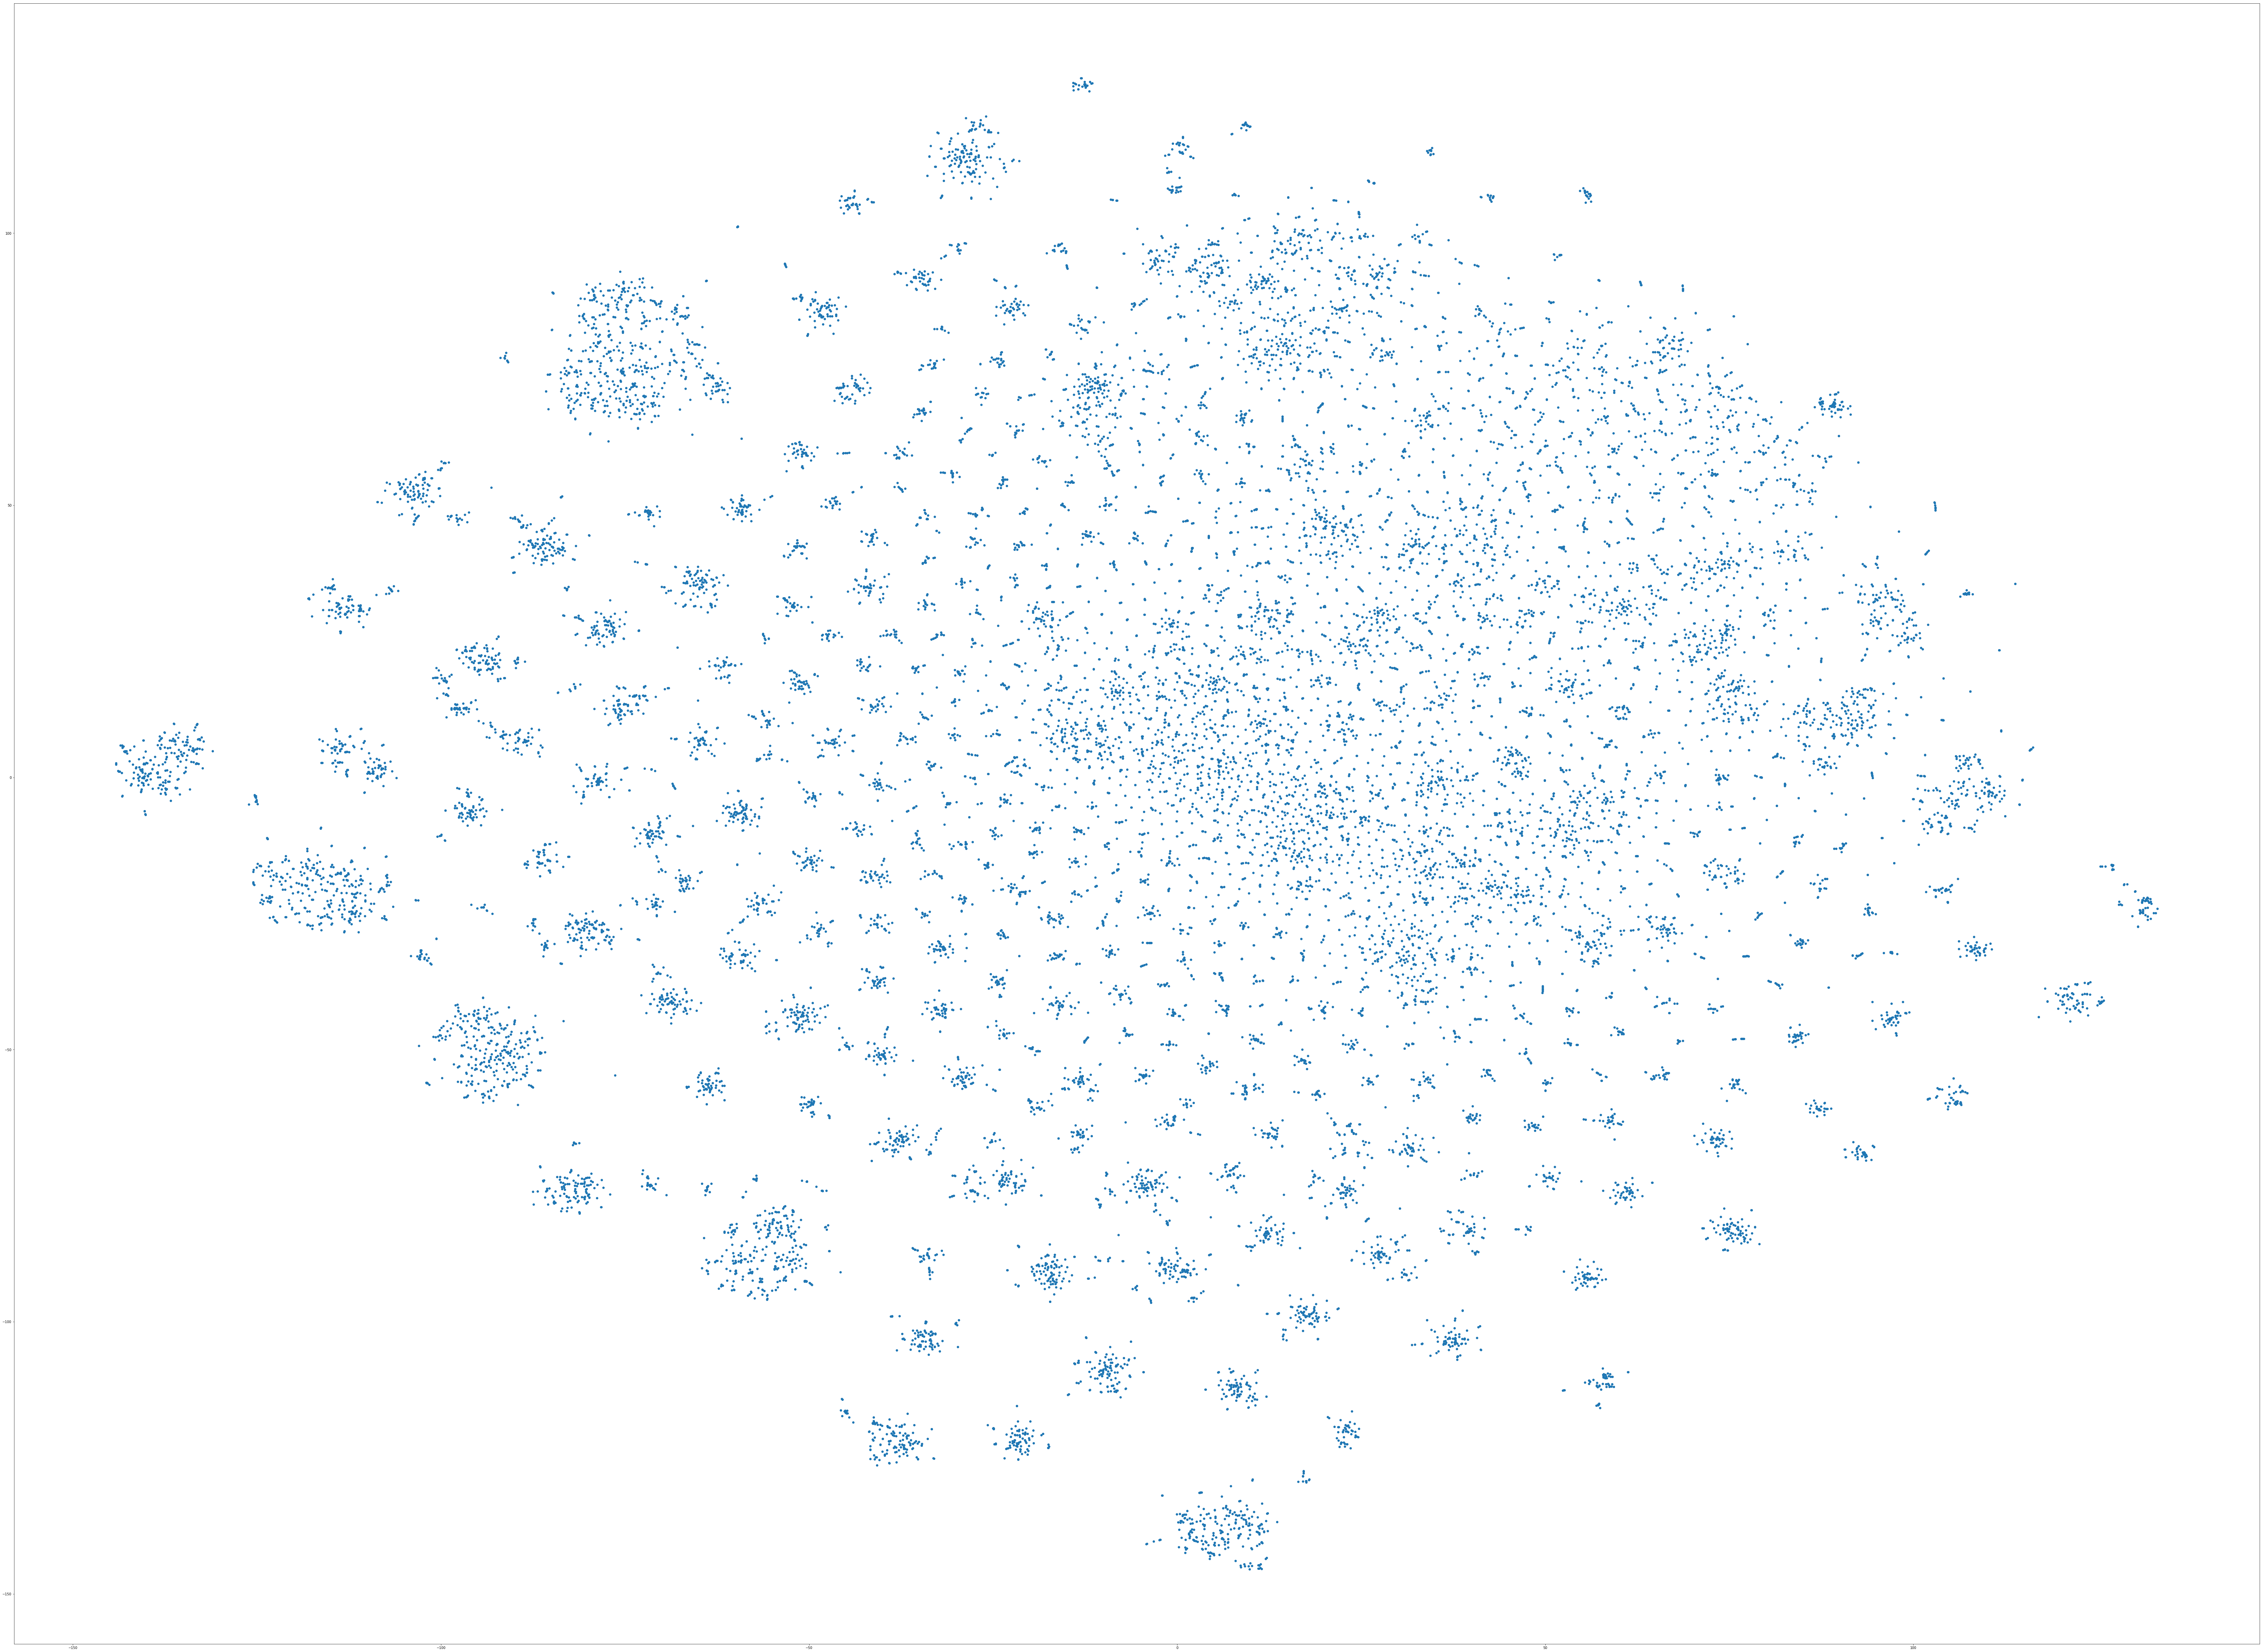

In [81]:
import numpy as np
from matplotlib import pyplot as plt
plt.scatter(df_tsne['x-tsne'], df_tsne['y-tsne'])
# plt.scatter(df_tsne['x-tsne'], df_tsne['y-tsne'], c=df['label'])
# plt.colorbar(ticks=range(200))
# plt.clim(-0.5, 199.5)
# plt.rcParams["figure.figsize"] = [120, 90] 
plt.show()

#### With LABEL visualization

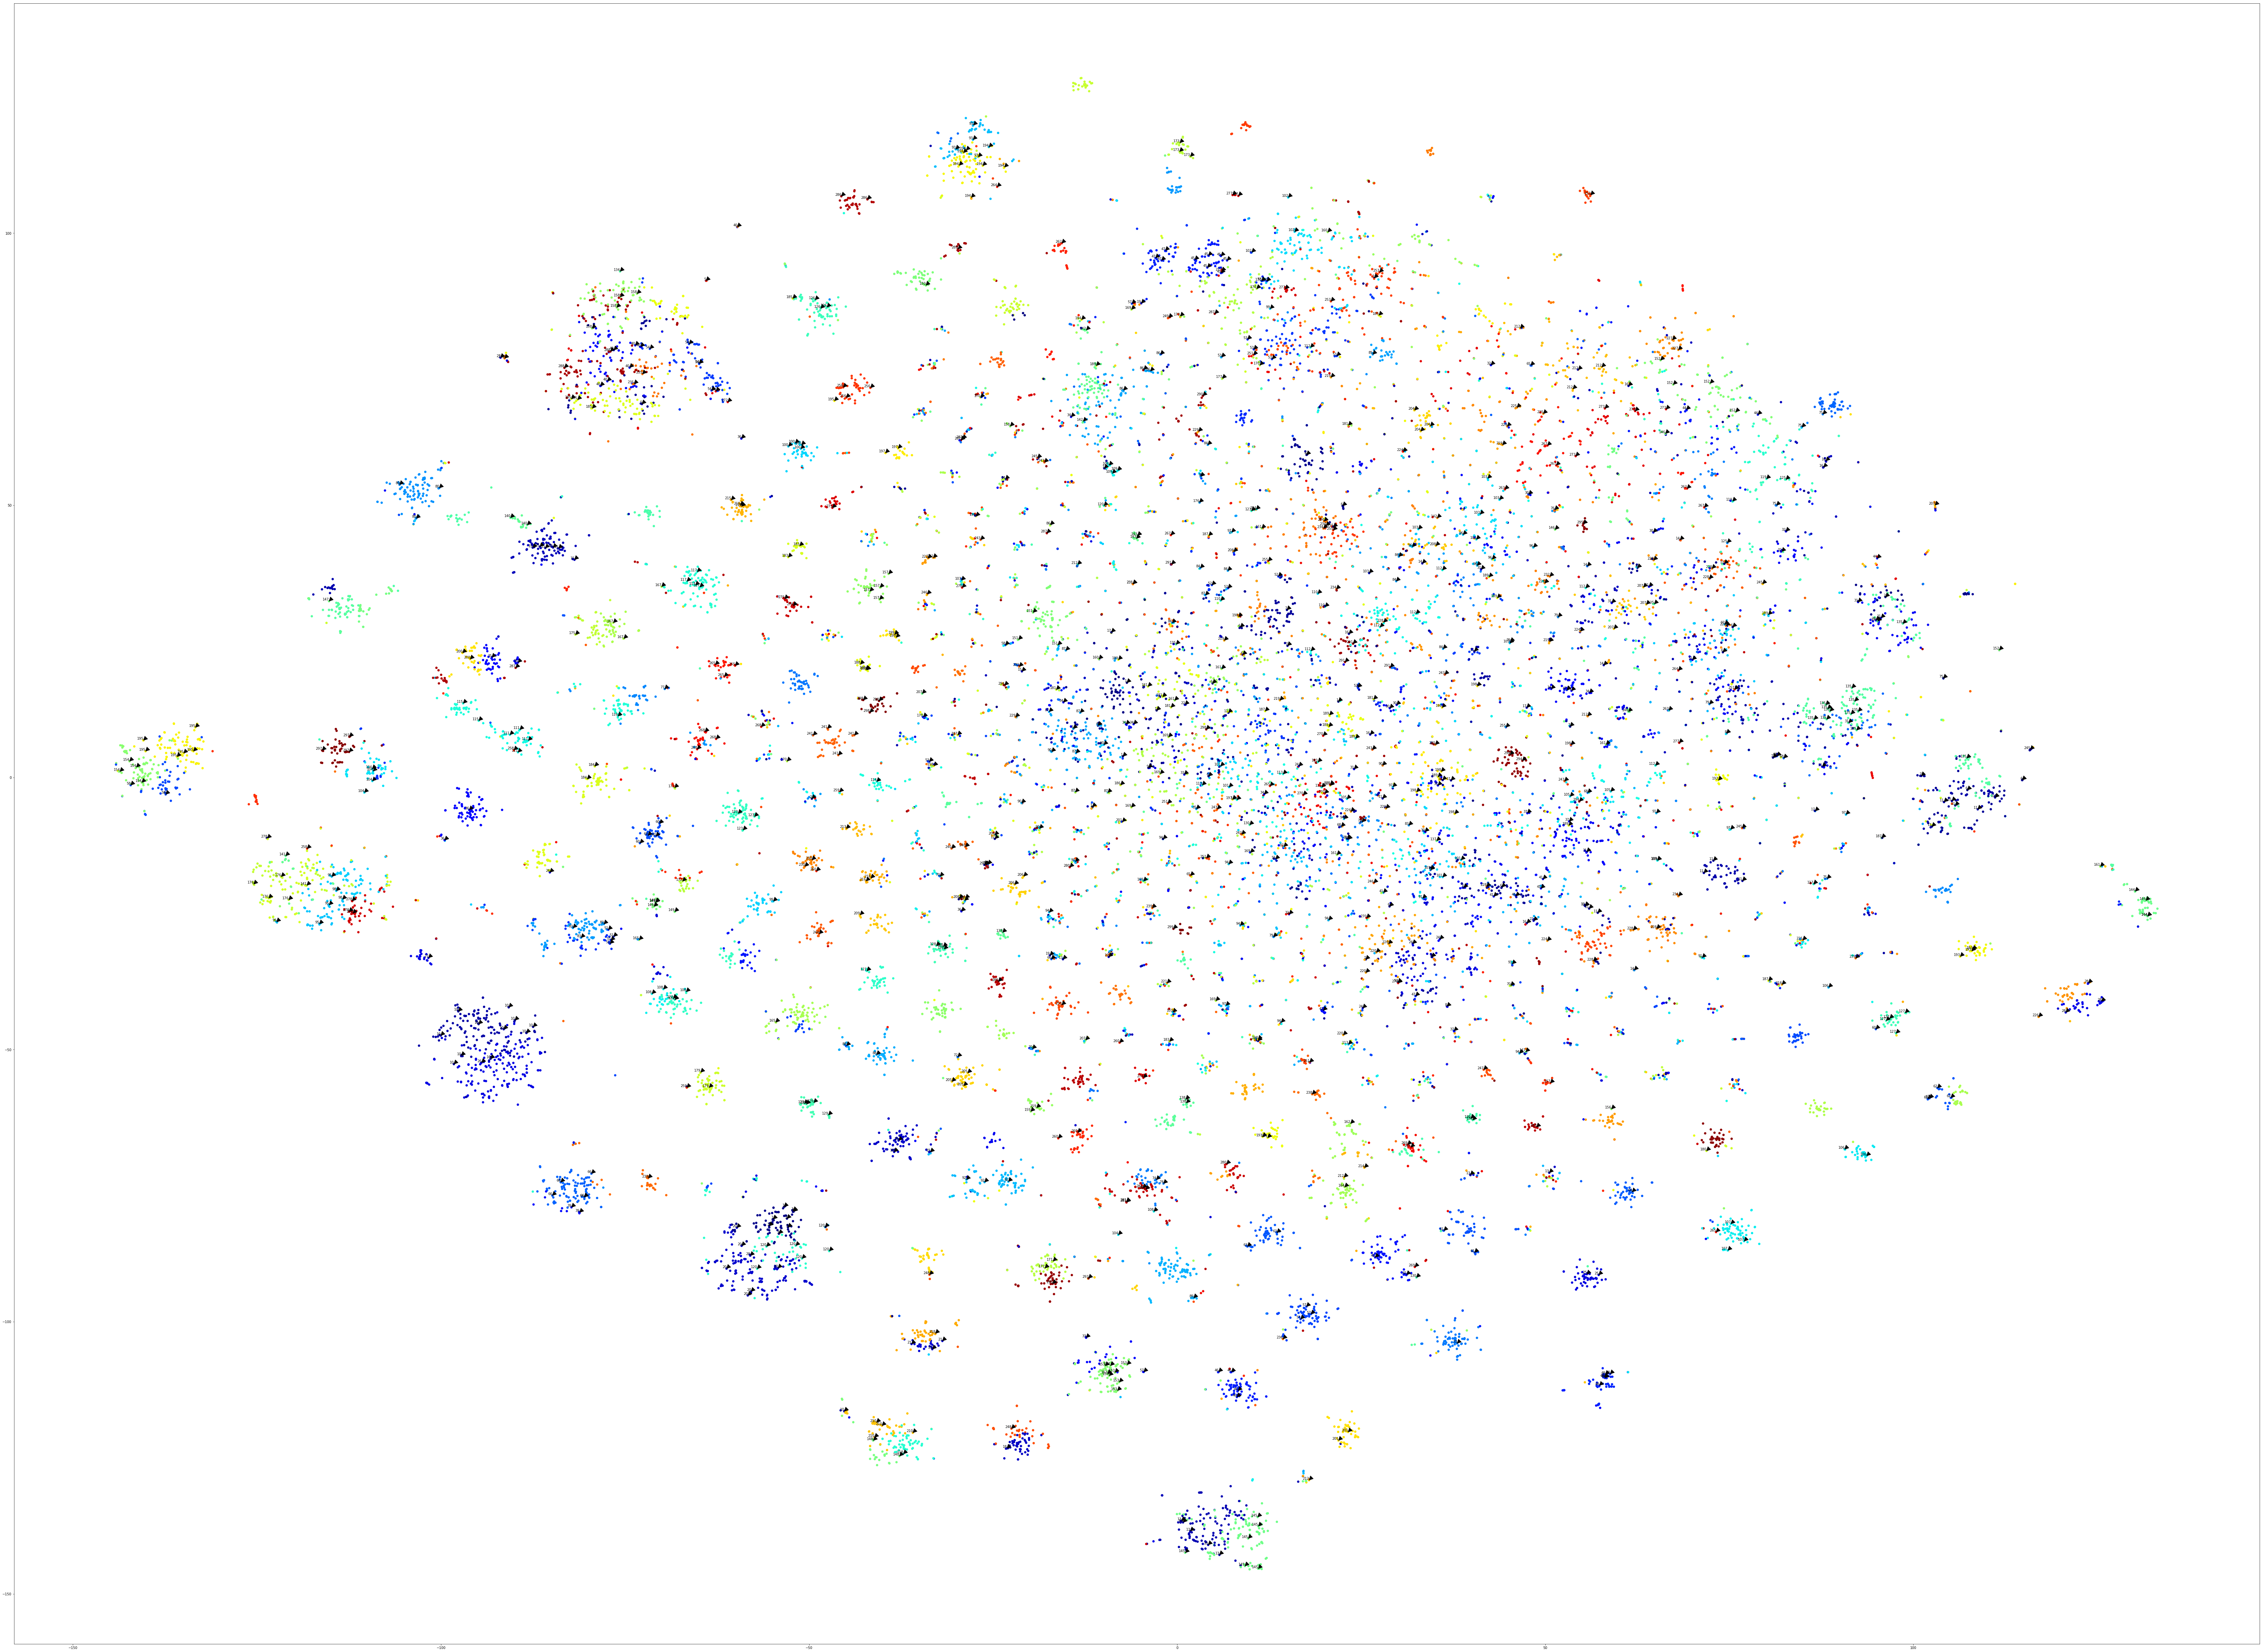

In [144]:
import random
import numpy as np
from matplotlib import pyplot as plt

# vdf['ward_label'] = ward.labels_
# vdf['ward_label'] = vdf['ward_label'].apply(lambda i: str(i))

# vdf['dbs_label'] = dbs.labels_
# vdf['dbs_label'] = vdf['dbs_label'].apply(lambda i: str(i))

# vdf['gmm100_label'] = model100_preds
# vdf['gmm100_label'] = vdf['gmm100_label'].apply(lambda i: str(i))

# vdf['gmm150_label'] = model150_preds
# vdf['gmm150_label'] = vdf['gmm150_label'].apply(lambda i: str(i))

# vdf['gmm200_label'] = model200_preds
# vdf['gmm200_label'] = vdf['gmm200_label'].apply(lambda i: str(i))

vdf['gmm300_label'] = model300_preds
vdf['gmm300_label'] = vdf['gmm300_label'].apply(lambda i: str(i))

label_name = 'gmm300_label'

plt.scatter(df_tsne['x-tsne'], df_tsne['y-tsne'], c=vdf[label_name], cmap=plt.cm.get_cmap("jet", 300))
# plt.scatter(df_tsne['x-tsne'], df_tsne['y-tsne'], c=df['label'])
# plt.colorbar(ticks=range(300))
# plt.clim(-0.5, 299.5)
for label, x, y in zip(vdf[label_name], df_tsne['x-tsne'], df_tsne['y-tsne']):
    p = random.random()
    if p < 1/20:
        plt.annotate(label, xy=(x, y), xytext=(0.15, 0.15), 
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     textcoords='offset points', ha='right', va='bottom',)
# plt.rcParams["figure.figsize"] = [120, 90] 
plt.show()

#### 3D visualization

In [ ]:
import time

from sklearn.manifold import TSNE

n_sne = 7000
n_dims = 3

time_start = time.time()
tsne = TSNE(n_components=n_dims, verbose=1, perplexity=40, n_iter=300)
tsne_res_3d = tsne.fit_transform(df.loc[:,feat_cols].values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
df_tsne_3d = df.loc[:,:].copy()
df_tsne_3d['x-tsne'] = tsne_res_3d[:,0]
df_tsne_3d['y-tsne'] = tsne_res_3d[:,1]
df_tsne_3d['z-tsne'] = tsne_res_3d[:,2]
import numpy as np
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(df_tsne_3d['x-tsne'], df_tsne_3d['y-tsne'], df_tsne_3d['z-tsne'], c=df['label'], cmap=plt.cm.get_cmap("jet", 200))
# plt.colorbar(ticks=range(200))
# plt.clim(-0.5, 199.5)
plt.rcParams["figure.figsize"] = [600, 200] 
plt.show()

In [246]:
# from ggplot import *

# chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \

# + geom_point(size=70,alpha=0.1) \
#         + ggtitle("tSNE dimensions colored by digit")
# chart

In [259]:
c0 = np.argsort(d[:,1])[:70]
data_array[c0][:,1]

array(['没有你，不赖',
       '哦，那你们真的跟那个东西应该没有没有没有什么活动，应该没有我也不能强求他们直接就试图在我们这边，他们现在的活动吧。',
       '做保险啦，感觉没有我没有买那的，嗯，这方面没有那边。', '嗯，你说没有', '那这个就没有没有那个跟他是一样的',
       '还有什么优惠吗没有了吗嗯没有没有', '是你没有亲密', '你那有没有', '是你是想到现在没有没有没。',
       '没有没有，我在房子这边。', '那那是最低的是吧也没有嗯也没有再那个低点是吧',
       '那你们优惠呀，那你这个跟她我还那这个就没有，没有那个跟他是一样的。',
       '嗯，在哪下，您这个车子买来到现在你有没有找保险公司理赔过的呀。', '没有，我也没做过保险呢？', '啊，都没有码头的',
       '嗯，没有没有，就是宝就是买的兴趣了。', '没有我就是', '没有没有，你是一个',
       '都是我们为你们这个有什么优惠没有什么优惠都没有，但那我。', '如果没有做的都有了吗？', '他说没有辞啊', '因为我是没有',
       '都没有的她我问过他了吗他说', '没有。因为我也没有没有出问题。', '有没有去过你看不到吗？',
       '没有没有的啊，我当时也是在外地出的时候我，但是也是到宁波这边，然后再定损呢？', '嗯没有的', '嗯，没有的',
       '那你们这边就是买你们保险你没有没有什么。', '哦你先算一下哦我没有任何的那个就是没有出过事故', '你也没有说',
       '这个就不要打听了，反正有没有再优惠了没有事吗就，反正我。',
       '那你就是大概大致算消失。参考一下。我现在还还没有选保险公司，因为我的说还没有。',
       '嗯第二年是有中间的人去去给我介绍的嗯没有在没有在那个', '我跟你说一下哈，老师因为去年呢你没有买这个。', '没有了是吧？',
       '我放在你们那也没有利息，什么也没有，为什么我可以在外面做理财呀。', '没有啊，我情妇',
       '就在今年吗？没有。然后就说第一年的时候我抱过那个。', '没有，这就找武力的车了，我呢。',
       '他也没有保险那个没有这个吧，你们一样的发给公司吗？你们

In [249]:
from collections import Counter
Counter(km.labels_)

Counter({0: 64,
         1: 174,
         2: 45,
         3: 178,
         4: 18,
         5: 19,
         6: 63,
         7: 62,
         8: 102,
         9: 53,
         10: 82,
         11: 70,
         12: 31,
         13: 4,
         14: 250,
         15: 52,
         16: 207,
         17: 67,
         18: 48,
         19: 427,
         20: 70,
         21: 14,
         22: 109,
         23: 386,
         24: 46,
         25: 163,
         26: 200,
         27: 96,
         28: 69,
         29: 40,
         30: 66,
         31: 210,
         32: 125,
         33: 149,
         34: 7,
         35: 99,
         36: 143,
         37: 82,
         38: 47,
         39: 14,
         40: 23,
         41: 40,
         42: 78,
         43: 18,
         44: 97,
         45: 98,
         46: 87,
         47: 84,
         48: 50,
         49: 289,
         50: 76,
         51: 60,
         52: 119,
         53: 19,
         54: 44,
         55: 11,
         56: 172,
         57: 43,
         